In [27]:
from lcdb.db import LCDB
from lcdb.analysis.util import LearningCurveExtractor
from lcdb.analysis.util import merge_curves

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
datasets = [3]#, 6, 11, 12]
workflows = [
    "lcdb.workflow.sklearn.KNNWorkflow",
    "lcdb.workflow.sklearn.LibLinearWorkflow",
    "lcdb.workflow.sklearn.LibSVMWorkflow",
    "lcdb.workflow.sklearn.TreesEnsembleWorkflow"
]

# retrieve learning curve objects
lcdb = LCDB()
df = lcdb.query(
    openmlids=[3],
    workflows=workflows[1],
    return_generator=False,
    processors={
        "learning_curve": LearningCurveExtractor(
            metrics=["error_rate"],
            folds=["train", "val"]
        )
    },
    show_progress=True
)

# group by configurations
config_cols = [c for c in df.columns if c.startswith("p:")]
df = df.groupby(config_cols).agg({"learning_curve": merge_curves})
print(df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.72it/s]

                                                                                                                                                                                                                                                                                                                                                                        learning_curve
p:C          p:class_weight p:dual p:fit_intercept p:intercept_scaling p:loss        p:max_iter p:multiclass p:penalty p:pp@cat_encoder p:pp@decomposition p:pp@featuregen p:pp@featureselector p:pp@scaler p:tol    p:pp@kernel_pca_kernel p:pp@kernel_pca_n_components p:pp@poly_degree p:pp@selectp_percentile p:pp@std_with_std                                                   
1.700000e-12 balanced       True   True            48.100530           squared_hinge 333        ovo-scikit   l2        onehot           none               none            none                 none        0.167642 linear                 0.25          

In [55]:
df

,,,,,,,,,,,,,,,,,,,,learning_curve
p:C,p:class_weight,p:dual,p:fit_intercept,p:intercept_scaling,p:loss,p:max_iter,p:multiclass,p:penalty,p:pp@cat_encoder,p:pp@decomposition,p:pp@featuregen,p:pp@featureselector,p:pp@scaler,p:tol,p:pp@kernel_pca_kernel,p:pp@kernel_pca_n_components,p:pp@poly_degree,p:pp@selectp_percentile,p:pp@std_with_std,
1.700000e-12,balanced,True,True,48.100530,squared_hinge,333,ovo-scikit,l2,onehot,none,none,none,none,0.167642,linear,0.25,2,25,True,<lcdb.analysis.util.LearningCurve object at 0x...
2.100000e-12,none,False,False,9.696052,squared_hinge,3614,ovr,l2,onehot,agglomerator,poly,none,none,0.039397,linear,0.25,2,25,True,<lcdb.analysis.util.LearningCurve object at 0x...
3.300000e-12,none,True,False,1.064434,hinge,2494,ovo-scikit,l2,ordinal,agglomerator,none,selectp,std,0.009632,linear,0.25,2,61,False,<lcdb.analysis.util.LearningCurve object at 0x...
6.400000e-12,none,True,False,2.303190,squared_hinge,310,ovr,l2,onehot,agglomerator,none,none,none,0.000244,linear,0.25,2,25,True,<lcdb.analysis.util.LearningCurve object at 0x...
8.800000e-12,none,False,False,13.663125,squared_hinge,2670,ovo-scikit,l1,ordinal,ka_rbf,none,selectp,std,0.039527,linear,0.25,2,89,True,<lcdb.analysis.util.LearningCurve object at 0x...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.181939e+10,none,True,False,22.980967,hinge,7901,ovr,l2,onehot,none,none,none,std,0.349381,linear,0.25,2,25,True,<lcdb.analysis.util.LearningCurve object at 0x...
2.603856e+10,balanced,True,True,765.127535,squared_hinge,813,ovo-scikit,l2,onehot,lda,none,none,none,0.005818,linear,0.25,2,25,True,<lcdb.analysis.util.LearningCurve object at 0x...
1.613674e+11,balanced,True,True,135.249005,hinge,139,ovo-scikit,l2,onehot,agglomerator,none,none,std,0.000204,linear,0.25,2,25,True,<lcdb.analysis.util.LearningCurve object at 0x...


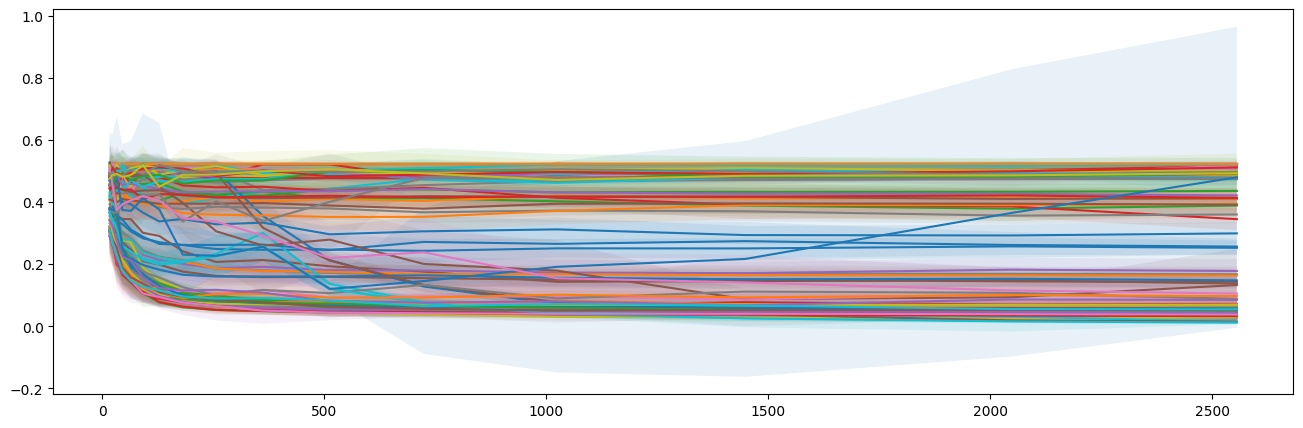

In [15]:
fig, ax = plt.subplots(figsize=(16, 5))
for lc in df["learning_curve"]:
    schedule = lc.anchors_size
    lc = lc.values[0, 1] # validation error rate
    
    mu = lc.mean(axis=(0,1)).squeeze()
    std = lc.std(axis=(0,1)).squeeze()
    ax.plot(schedule, mu)
    ax.fill_between(schedule, mu - std, mu + std, alpha=0.1)
    
plt.show()

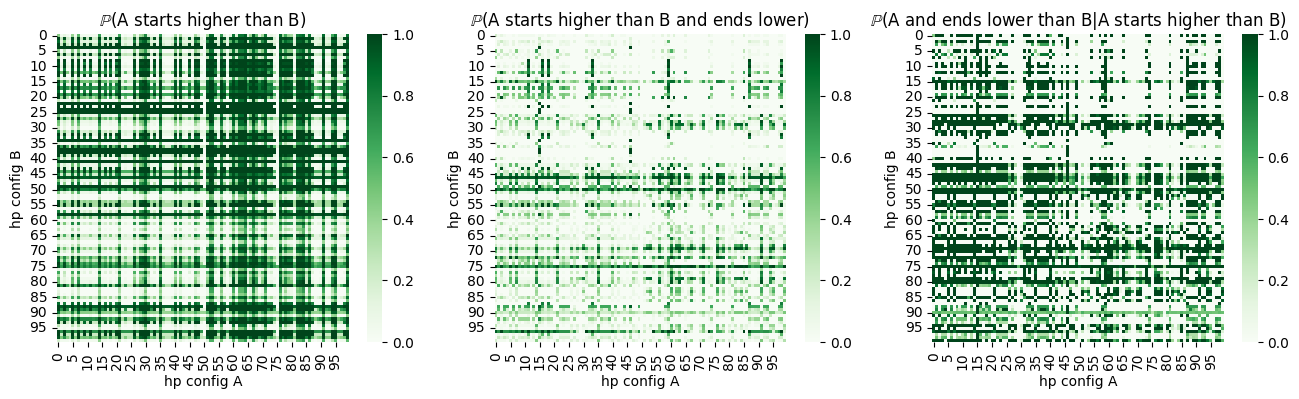

In [54]:
def learning_curve_crossing_evaluation(df):
    
    # compute diffs at different anchors
    diffs = np.zeros((len(df), len(df), len(df["learning_curve"].iloc[0].test_seeds), len(df["learning_curve"].iloc[0].val_seeds), len(df["learning_curve"].iloc[0].workflow_seeds), len(df["learning_curve"].iloc[0].anchors_size)))
    for i, lc1 in enumerate(df["learning_curve"]):
        curve1 = lc1.values[0, 1]
        for j, lc2 in enumerate(df["learning_curve"]):
            curve2 = lc2.values[0, 1].mean(axis=(0, 1)).squeeze()
            diffs[i, j] = curve1 - curve2
    diffs_bin = diffs > 0
    
    # compute P(A starts lower than B)
    probs_a_starts_higher_than_b = diffs_bin[:,:,:,:,:,0].mean(axis=(2, 3, 4))
    
    # compute P(A starts lower than B and finishes higher)
    probs_a_strats_higher_than_b_and_ends_lower_than_b = (diffs_bin[:,:,:,:,:,0] & ~diffs_bin[:,:,:,:,:,-1]).mean(axis=(2, 3, 4))
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    sb.heatmap(probs_a_starts_higher_than_b, cmap="Greens", ax=axs[0])
    sb.heatmap(probs_a_strats_higher_than_b_and_ends_lower_than_b, cmap="Greens", ax=axs[1])
    sb.heatmap(probs_a_strats_higher_than_b_and_ends_lower_than_b / np.maximum(10**-10, probs_a_starts_higher_than_b), cmap="Greens", ax=axs[2])
    axs[0].set_title(r"$\mathbb{P}$(A starts higher than B)")
    axs[1].set_title(r"$\mathbb{P}$(A starts higher than B and ends lower)")
    axs[2].set_title(r"$\mathbb{P}$(A and ends lower than B|A starts higher than B)")
    
    for ax in axs:
        ax.set_xlabel("hp config A")
        ax.set_ylabel("hp config B")
    fig.savefig("plots/lc_crossing_liblinear.pdf", bbox_inches="tight")
    plt.show()
    
learning_curve_crossing_evaluation(df)

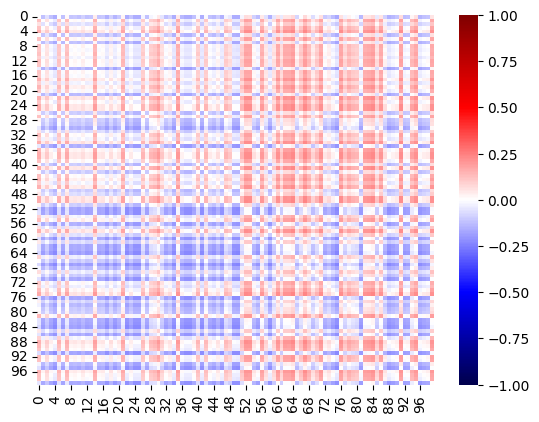

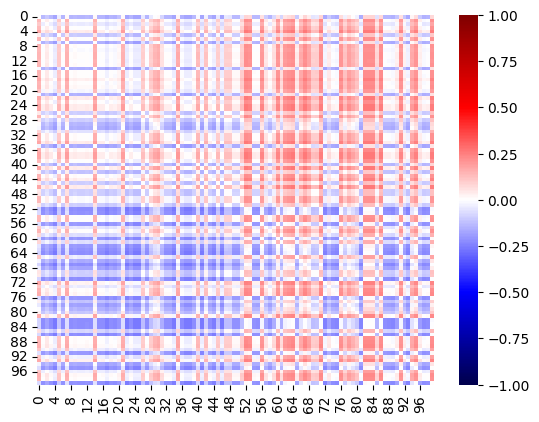

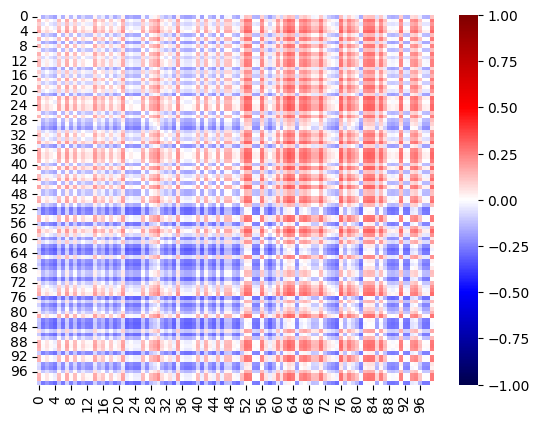

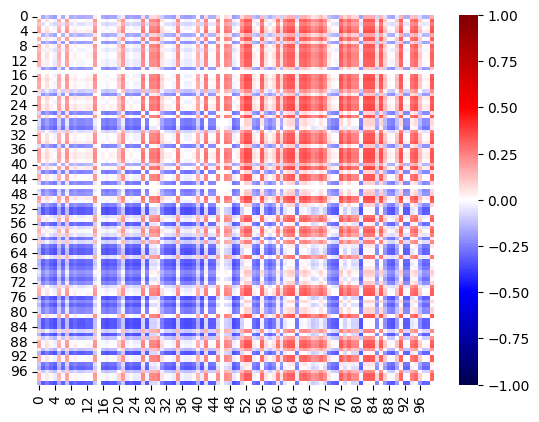

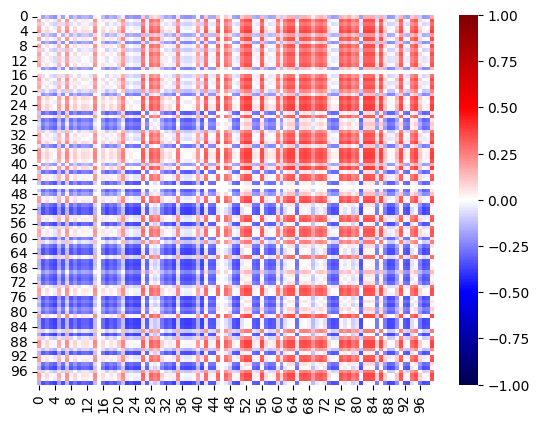

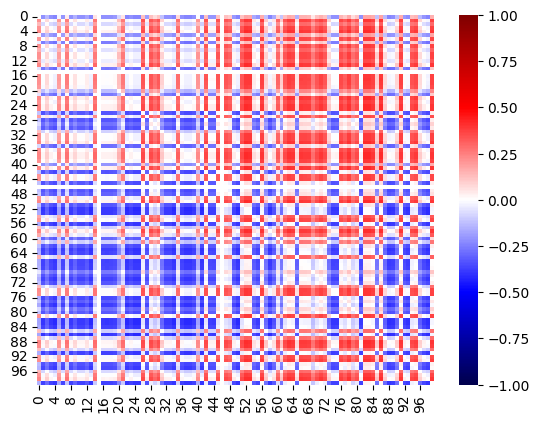

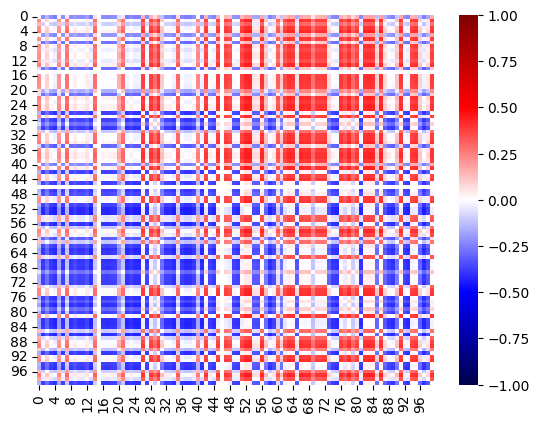

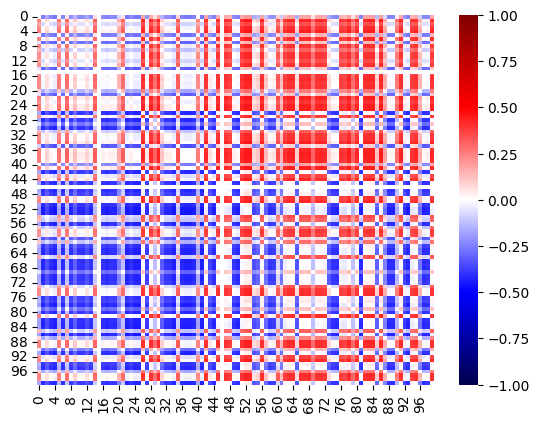

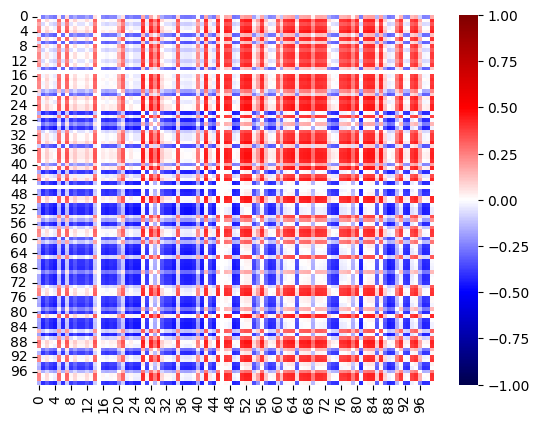

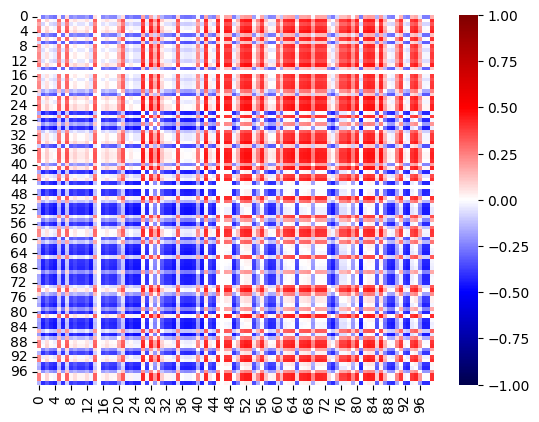

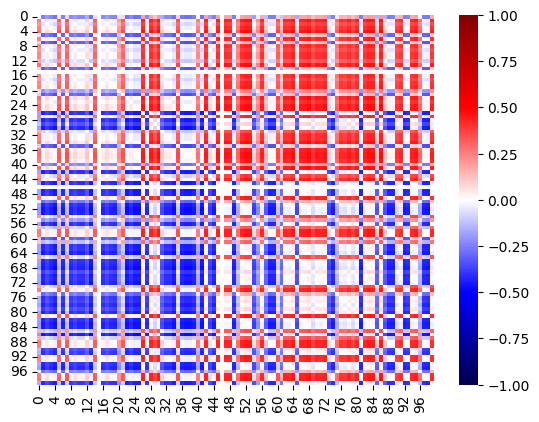

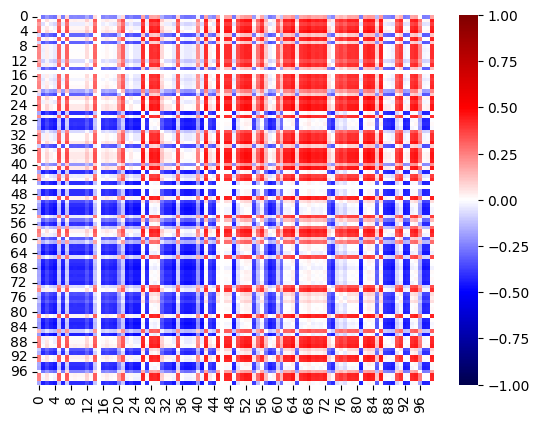

In [30]:
for i in range(12):
    fig, ax = plt.subplots()
    sb.heatmap(diffs[:, :, i], ax=ax, vmin=-1, vmax=1, cmap="seismic")
    plt.show()